## Test ML models
### h2o.ai
Transform netCDF serialized files to h2o dataframes via xarray and pandas.

In [1]:
from dask.distributed import Client
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:40164 Dashboard: http://127.0.0.1:57880/status,Cluster Workers: 6 Cores: 24 Memory: 33.55 GB


In [164]:
client.close()

Exception ignored in: <generator object add_client at 0x7f7f502e85c8>
RuntimeError: generator ignored GeneratorExit
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 179, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line

In [2]:
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack

In [2]:

data_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/'
out_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'

t = eotempstack.S1TempStack(data_dir, out_dir, 'ASCENDING')


S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/


In [3]:
t.getTempData()

{'VV': [datetime.date(2018, 4, 8),
  datetime.date(2015, 11, 27),
  datetime.date(2016, 2, 7),
  datetime.date(2018, 4, 20),
  datetime.date(2015, 12, 21),
  datetime.date(2016, 1, 14)]}

In [4]:
t.out_directory+t.prod_type+'_'+t.orbit+'_'#+month+'.nc'

'/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/S1_ASCENDING_'

In [3]:
t.createXDataset()

In [9]:
from datetime import datetime as dt
from calendar import monthrange
time_ranges = list([(dt.strptime('01'+x.strftime('%m%Y'), '%d%m%Y').date(),
                            dt.strptime(str(monthrange(x.year, x.month)[1])+x.strftime('%m%Y'), '%d%m%Y').date()) for x in next(iter(t.getTempData().values()))])

In [11]:
list(time_ranges)

[(datetime.date(2015, 11, 1), datetime.date(2015, 11, 30)),
 (datetime.date(2015, 12, 1), datetime.date(2015, 12, 31)),
 (datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)),
 (datetime.date(2016, 2, 1), datetime.date(2016, 2, 29))]

In [15]:
t.getTempData()#.values()

{'VV_ASM': [],
 'VV_Contrast': [],
 'VV_Dissimilarity': [],
 'VV_Energy': [],
 'VV_Entropy': [],
 'VV_GLCMCorrelation': [],
 'VV_GLCMMean': [],
 'VV_GLCMVariance': [],
 'VV_Homogeneity': [],
 'VH_ASM': [],
 'VH_Contrast': [],
 'VH_Dissimilarity': [],
 'VH_Energy': [],
 'VH_Entropy': [],
 'VH_GLCMCorrelation': [],
 'VH_GLCMMean': [],
 'VH_GLCMVariance': [],
 'VH_Homogeneity': []}

In [ ]:
saldana = regionstack.regionStack('Saldana_training_2015')

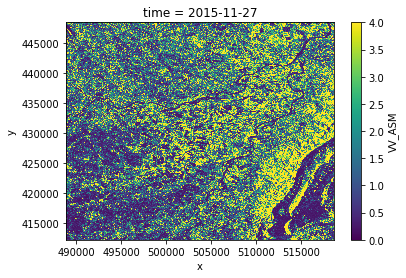

In [6]:
saldana.S1_ASCENDING_GLCM.isel(time=0).VV_ASM.plot()

In [9]:
saldana.S2

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    LSWI     (time, y, x) 

In [6]:
saldana.calcTempVariation('S2', ['NDVI','LSWI'])#,'red', 'green','blue','nir','swir1','swir2'])

Processing band NDVI for date 2015-12-21T00:00:00.000000000
Processing band NDVI for date 2015-12-31T00:00:00.000000000
Processing band NDVI for date 2016-01-10T00:00:00.000000000
Processing band NDVI for date 2016-01-20T00:00:00.000000000
Processing band NDVI for date 2016-01-30T00:00:00.000000000
Processing band NDVI for date 2016-02-09T00:00:00.000000000
Processing band NDVI for date 2016-02-19T00:00:00.000000000
Processing band LSWI for date 2015-12-21T00:00:00.000000000
Processing band LSWI for date 2015-12-31T00:00:00.000000000
Processing band LSWI for date 2016-01-10T00:00:00.000000000
Processing band LSWI for date 2016-01-20T00:00:00.000000000
Processing band LSWI for date 2016-01-30T00:00:00.000000000
Processing band LSWI for date 2016-02-09T00:00:00.000000000
Processing band LSWI for date 2016-02-19T00:00:00.000000000


In [9]:
#saldana.calcTempVariation('S1_ASCENDING', ['VV'])
saldana.calcTempVariation('S1_DESCENDING', ['VV'])
#saldana.S1_ASCENDING #[['NDVI_c','LSWI_c']]

Processing band VV for date 2015-12-28T00:00:00.000000000
Processing band VV for date 2016-01-21T00:00:00.000000000
Processing band VV for date 2016-02-14T00:00:00.000000000


In [17]:
ratio = saldana.S1_DESCENDING.VV / saldana.S1_DESCENDING.VH

In [4]:
shp_file = '/home/azalazar/data/saldana.shp'

saldana.regionTrainingClasses(shp_file, testset=0.3)

Adding dataset with classes as class_ds attribute of regionStack


In [5]:
data_dict = dict([('S1_DESCENDING',['VV','VV_c']),
                  ('S1_ASCENDING',['VV','VV_c']),
                  ('S1_ASCENDING_GLCM',['VV_ASM','VV_Contrast','VV_Dissimilarity',
                                        'VV_Energy','VV_Entropy','VV_GLCMCorrelation',
                                        'VV_GLCMMean','VV_GLCMVariance','VV_Homogeneity']),
                  ('S1_DESCENDING_GLCM',['VV_ASM','VV_Contrast','VV_Dissimilarity',
                                         'VV_Energy','VV_Entropy','VV_GLCMCorrelation',
                                         'VV_GLCMMean','VV_GLCMVariance','VV_Homogeneity'])])
data_dict

{'S1_DESCENDING': ['VV', 'VV_c'],
 'S1_ASCENDING': ['VV', 'VV_c'],
 'S1_ASCENDING_GLCM': ['VV_ASM',
  'VV_Contrast',
  'VV_Dissimilarity',
  'VV_Energy',
  'VV_Entropy',
  'VV_GLCMCorrelation',
  'VV_GLCMMean',
  'VV_GLCMVariance',
  'VV_Homogeneity'],
 'S1_DESCENDING_GLCM': ['VV_ASM',
  'VV_Contrast',
  'VV_Dissimilarity',
  'VV_Energy',
  'VV_Entropy',
  'VV_GLCMCorrelation',
  'VV_GLCMMean',
  'VV_GLCMVariance',
  'VV_Homogeneity']}

In [6]:
saldana.buildTrainingDataFrame(data_dict, ['test'])

Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test0/ . 1 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test1/ . 2 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test2/ . 3 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test3/ . 4 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test4/ . 5 of 6...
Writing test parquet dataset to /mnt/workspac

In [12]:
import numpy as np
for index, date in np.ndenumerate(saldana.S2.time.values):
    print(index[0])

0
1
2
3
4
5
6
7


In [18]:
import numpy as np
test = np.array([1,2,3,4,5,5])
np.unique(test)

array([1, 2, 3, 4, 5])

In [12]:
import numpy as np
a = np.array([], dtype=np.datetime64)
a = np.append(a, saldana.S2.time.values)
#print(a)
#for num in range(10):
#    print(num)
#    a = np.append(a, num)
print(a)

['2015-12-11T00:00:00.000000000' '2015-12-21T00:00:00.000000000'
 '2015-12-31T00:00:00.000000000' '2016-01-10T00:00:00.000000000'
 '2016-01-20T00:00:00.000000000' '2016-01-30T00:00:00.000000000'
 '2016-02-09T00:00:00.000000000' '2016-02-19T00:00:00.000000000']


In [11]:
saldana.S1_DESCENDING_GLCM = saldana.S1_DESCENCDING_GLCM

In [12]:
saldana.train#.to_netcdf(saldana.data_directory+'train.nc')#, chunks={'time':1})

AttributeError: 'regionStack' object has no attribute 'train'

In [21]:
client

Client Scheduler: tcp://127.0.0.1:41298 Dashboard: http://127.0.0.1:55865/status,Cluster Workers: 4 Cores: 24 Memory: 33.55 GB


In [27]:
t_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/'
train_data = xr.open_mfdataset(t_dir+'train.nc', chunks={'time':1, 'x':1000,'y':1220})
train_data

<xarray.Dataset>
Dimensions:   (time: 4, x: 2981, y: 3635)
Coordinates:
  * y         (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time      (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 2016-01-10
    mask      (time, x, y) bool dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
Data variables:
    NDVI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    LSWI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_ASC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VH_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    train     (time, x, y) float64 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
   

In [190]:
saldana.S1_DESCENDING.time.values

array(['2015-12-04T00:00:00.000000000', '2015-12-28T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-02-14T00:00:00.000000000'],
      dtype='datetime64[ns]')

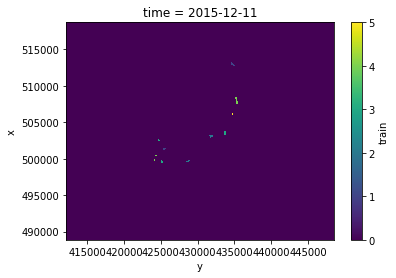

In [18]:
train_data.train.isel(time=0).plot()

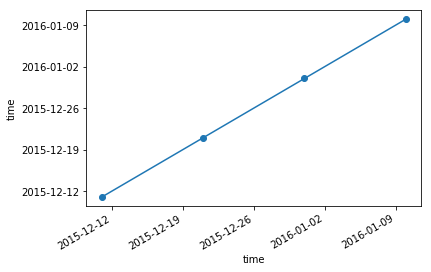

In [37]:
saldana.train.time.plot(marker='o')

### Machine learning with h2o.ai

In [1]:
import h2o

In [33]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda3/envs/models3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpg25folmr
  JVM stdout: /tmp/tmpg25folmr/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmpg25folmr/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,4 months and 12 days !!!
H2O cluster name:,H2O_from_python_azalazar_81j2wr
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


In [34]:
import os

data = h2o.import_file(os.environ['WIN_SVR_DATA']+'Saldana2/featdf/')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
data

IDLote,NDVI_0,NDVI_16,NDVI_32,NDVI_n112,NDVI_n16,NDVI_n32,NDVI_n48,NDVI_n64,NDVI_n80,NDVI_n96,VV_0,VV_16,VV_32,VV_ASM_0,VV_ASM_16,VV_ASM_32,VV_ASM_n112,VV_ASM_n128,VV_ASM_n144,VV_ASM_n16,VV_ASM_n160,VV_ASM_n176,VV_ASM_n192,VV_ASM_n208,VV_ASM_n32,VV_ASM_n48,VV_ASM_n64,VV_ASM_n80,VV_ASM_n96,VV_Contrast_0,VV_Contrast_16,VV_Contrast_32,VV_Contrast_n112,VV_Contrast_n128,VV_Contrast_n144,VV_Contrast_n16,VV_Contrast_n160,VV_Contrast_n176,VV_Contrast_n192,VV_Contrast_n208,VV_Contrast_n32,VV_Contrast_n48,VV_Contrast_n64,VV_Contrast_n80,VV_Contrast_n96,VV_Dissimilarity_0,VV_Dissimilarity_16,VV_Dissimilarity_32,VV_Dissimilarity_n112,VV_Dissimilarity_n128,VV_Dissimilarity_n144,VV_Dissimilarity_n16,VV_Dissimilarity_n160,VV_Dissimilarity_n176,VV_Dissimilarity_n192,VV_Dissimilarity_n208,VV_Dissimilarity_n32,VV_Dissimilarity_n48,VV_Dissimilarity_n64,VV_Dissimilarity_n80,VV_Dissimilarity_n96,VV_Energy_0,VV_Energy_16,VV_Energy_32,VV_Energy_n112,VV_Energy_n128,VV_Energy_n144,VV_Energy_n16,VV_Energy_n160,VV_Energy_n176,VV_Energy_n192,VV_Energy_n208,VV_Energy_n32,VV_Energy_n48,VV_Energy_n64,VV_Energy_n80,VV_Energy_n96,VV_Entropy_0,VV_Entropy_16,VV_Entropy_32,VV_Entropy_n112,VV_Entropy_n128,VV_Entropy_n144,VV_Entropy_n16,VV_Entropy_n160,VV_Entropy_n176,VV_Entropy_n192,VV_Entropy_n208,VV_Entropy_n32,VV_Entropy_n48,VV_Entropy_n64,VV_Entropy_n80,VV_Entropy_n96,VV_GLCMCorrelation_0,VV_GLCMCorrelation_16,VV_GLCMCorrelation_32,VV_GLCMCorrelation_n112,VV_GLCMCorrelation_n128,VV_GLCMCorrelation_n144,VV_GLCMCorrelation_n16,VV_GLCMCorrelation_n160,VV_GLCMCorrelation_n176,VV_GLCMCorrelation_n192,VV_GLCMCorrelation_n208,VV_GLCMCorrelation_n32,VV_GLCMCorrelation_n48,VV_GLCMCorrelation_n64,VV_GLCMCorrelation_n80,VV_GLCMCorrelation_n96,VV_GLCMMean_0,VV_GLCMMean_16,VV_GLCMMean_32,VV_GLCMMean_n112,VV_GLCMMean_n128,VV_GLCMMean_n144,VV_GLCMMean_n16,VV_GLCMMean_n160,VV_GLCMMean_n176,VV_GLCMMean_n192,VV_GLCMMean_n208,VV_GLCMMean_n32,VV_GLCMMean_n48,VV_GLCMMean_n64,VV_GLCMMean_n80,VV_GLCMMean_n96,VV_GLCMVariance_0,VV_GLCMVariance_16,VV_GLCMVariance_32,VV_GLCMVariance_n112,VV_GLCMVariance_n128,VV_GLCMVariance_n144,VV_GLCMVariance_n16,VV_GLCMVariance_n160,VV_GLCMVariance_n176,VV_GLCMVariance_n192,VV_GLCMVariance_n208,VV_GLCMVariance_n32,VV_GLCMVariance_n48,VV_GLCMVariance_n64,VV_GLCMVariance_n80,VV_GLCMVariance_n96,VV_Homogeneity_0,VV_Homogeneity_16,VV_Homogeneity_32,VV_Homogeneity_n112,VV_Homogeneity_n128,VV_Homogeneity_n144,VV_Homogeneity_n16,VV_Homogeneity_n160,VV_Homogeneity_n176,VV_Homogeneity_n192,VV_Homogeneity_n208,VV_Homogeneity_n32,VV_Homogeneity_n48,VV_Homogeneity_n64,VV_Homogeneity_n80,VV_Homogeneity_n96,VV_n112,VV_n128,VV_n144,VV_n16,VV_n160,VV_n176,VV_n192,VV_n208,VV_n32,VV_n48,VV_n64,VV_n80,VV_n96,time,tt,vclass,x,y,__index_level_0__
21C914,0.282755,0.301326,nan,nan,0.237963,0.886977,1.08404,0.884083,0.604007,0.401498,-6.81144,-9.50691,nan,-0.0148192,-0.165639,nan,2.70233,0.233923,0.359993,4.40326,0.664309,1.75831,0.571546,nan,-0.93358,0.473584,0.421863,0.15936,0.780442,41.8622,16.8198,nan,-3.06328,-10.1589,78.8441,-27.6502,19.0516,-36.933,36.0568,nan,135.991,5.12496,9.14076,24.6476,6.92442,7.53337,4.50843,nan,-0.172035,1.3565,9.7209,-1.97151,3.19976,-3.68256,6.47784,nan,10.4025,2.7044,3.95341,4.91113,2.62751,0.403614,0.421322,nan,1.70697,0.616559,0.555831,2.12353,0.802769,1.42604,0.722651,nan,-0.142388,0.631041,0.676203,0.526454,0.895009,4.65294,4.45107,nan,-0.586453,3.06791,4.06458,-1.96141,2.60074,-0.540986,2.94295,nan,2.71806,2.59412,3.69741,4.10838,2.31707,0.824696,0.874445,nan,0.9276,0.93371,0.565192,1.01165,0.837912,1.14738,0.579383,nan,0.198218,0.697833,0.901603,0.868479,0.991084,14.8682,10.9121,nan,2.62375,7.23629,10.0192,-1.52636,5.2672,-0.141424,6.8101,nan,19.1867,4.99048,7.86409,18.0371,29.7947,121.586,70.8866,nan,22.1279,32.4738,83.3017,-54.3141,25.5542,-31.0305,37.833,nan,285.999,13.8577,35.1977,187.974,428.365,0.448537,0.560812,nan,1.89568,1.05223,0.408397,2.11421,1.17585,2.02134,0.708882,nan,-0.139036,0.724973,0.659135,0.813096,1.07129,-13.8

In [42]:
data['vclass'] = data['vclass'].asfactor()

In [37]:
data['vclass'].levels()

[['1', '2', '3', '4', '5']]

In [38]:
train = data[data['tt']=='train']

In [39]:
train.shape

(31416, 177)

In [85]:
test = data[data['tt']=='test']
test.shape

(9977, 177)

In [41]:
data = data[data['time']!=1448582400000000]

In [146]:
data['train'] = data['train'].ascharacter()
data['train'] = data['train'].asfactor()
data['train'].levels()

[['1', '2', '3', '4', '5']]

In [10]:
# To train and test the model using only this data, split data
train, valid = train.split_frame(ratios=[0.5], seed=10)

In [43]:
# Show number of observations from each dataset
print(train.nrow)
print(valid.nrow)

31416
15639


In [44]:
# Define response variables and predictors
y = 'vclass'
x = list(data.columns)

In [14]:
x.remove(y)
x.remove('IDLote')
x.remove('x')
x.remove('y')
x.remove('__index_level_0__')

In [45]:
x = []

for band in ['NDVI','VV','VV_ASM','VV_Contrast','VV_Dissimilarity','VV_Energy','VV_Entropy','VV_GLCMCorrelation',
            'VV_GLCMMean', 'VV_GLCMVariance', 'VV_Homogeneity']:
    for time in ['_0','_16','_n16','_n32','_n48','_n64','_n80','_n96']:
        x.append(band+time)

print(x)

['NDVI_0', 'NDVI_16', 'NDVI_n16', 'NDVI_n32', 'NDVI_n48', 'NDVI_n64', 'NDVI_n80', 'NDVI_n96', 'VV_0', 'VV_16', 'VV_n16', 'VV_n32', 'VV_n48', 'VV_n64', 'VV_n80', 'VV_n96', 'VV_ASM_0', 'VV_ASM_16', 'VV_ASM_n16', 'VV_ASM_n32', 'VV_ASM_n48', 'VV_ASM_n64', 'VV_ASM_n80', 'VV_ASM_n96', 'VV_Contrast_0', 'VV_Contrast_16', 'VV_Contrast_n16', 'VV_Contrast_n32', 'VV_Contrast_n48', 'VV_Contrast_n64', 'VV_Contrast_n80', 'VV_Contrast_n96', 'VV_Dissimilarity_0', 'VV_Dissimilarity_16', 'VV_Dissimilarity_n16', 'VV_Dissimilarity_n32', 'VV_Dissimilarity_n48', 'VV_Dissimilarity_n64', 'VV_Dissimilarity_n80', 'VV_Dissimilarity_n96', 'VV_Energy_0', 'VV_Energy_16', 'VV_Energy_n16', 'VV_Energy_n32', 'VV_Energy_n48', 'VV_Energy_n64', 'VV_Energy_n80', 'VV_Energy_n96', 'VV_Entropy_0', 'VV_Entropy_16', 'VV_Entropy_n16', 'VV_Entropy_n32', 'VV_Entropy_n48', 'VV_Entropy_n64', 'VV_Entropy_n80', 'VV_Entropy_n96', 'VV_GLCMCorrelation_0', 'VV_GLCMCorrelation_16', 'VV_GLCMCorrelation_n16', 'VV_GLCMCorrelation_n32', 'VV_GLC

In [46]:
# test random forest
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [47]:
# Initialize model
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=500,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=100)

In [48]:
# Train model
rf_v1.train(x, y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [49]:
# Print model details
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_covType_v1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.005022567893281561
RMSE: 0.07087007755944368
LogLoss: 0.033714301338326334
Mean Per-Class Error: 0.0010380608685901017
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
4624.0,1.0,1.0,0.0,0.0,0.0004323,"2 / 4,626"
1.0,4717.0,2.0,7.0,0.0,0.0021155,"10 / 4,727"
0.0,0.0,9030.0,6.0,0.0,0.0006640,"6 / 9,036"
1.0,7.0,0.0,9174.0,3.0,0.0011976,"11 / 9,185"
0.0,0.0,0.0,3.0,3839.0,0.0007808,"3 / 3,842"
4626.0,4725.0,9033.0,9190.0,3842.0,0.0010186,"32 / 31,416"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9989814
2,0.9999363
3,0.9999363
4,0.9999363
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2018-07-18 09:03:01,0.070 sec,0.0,nan,nan,nan
,2018-07-18 09:03:05,3.546 sec,1.0,0.1893245,1.0189254,0.0352972
,2018-07-18 09:03:05,4.128 sec,2.0,0.1673145,0.7564199,0.0270798
,2018-07-18 09:03:06,4.642 sec,3.0,0.1602790,0.6698992,0.0240918
,2018-07-18 09:03:07,5.176 sec,4.0,0.1481184,0.5364082,0.0197781
---,---,---,---,---,---,---
,2018-07-18 09:03:12,11.122 sec,20.0,0.0735044,0.0360426,0.0012734
,2018-07-18 09:03:13,11.424 sec,21.0,0.0725897,0.0330913,0.0012415
,2018-07-18 09:03:13,11.743 sec,22.0,0.0721105,0.0332856,0.0011460
,2018-07-18 09:03:13,12.028 sec,23.0,0.0715013,0.0338230,0.0010823



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NDVI_0,35540.3945312,1.0,0.0885626
NDVI_n64,34640.1132812,0.9746688,0.0863192
NDVI_n16,34115.9453125,0.9599203,0.0850131
NDVI_n80,30896.3457031,0.8693304,0.0769902
NDVI_n32,26942.0019531,0.7580670,0.0671364
---,---,---,---
VV_Homogeneity_n80,286.5029297,0.0080613,0.0007139
VV_Entropy_n64,270.2827759,0.0076049,0.0006735
VV_GLCMCorrelation_n96,246.4607391,0.0069347,0.0006142
VV_GLCMCorrelation_n80,236.1168976,0.0066436,0.0005884



See the whole table with table.as_data_frame()


In [50]:
predictions = rf_v1.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [51]:
predictions

predict,p1,p2,p3,p4,p5
4,0.0416667,0.0416667,0.0416667,0.791667,0.0833333
4,0.0481718,0.0951828,0.0951828,0.713871,0.0475914
5,0,0.266667,0,0.166667,0.566667
5,0,0.280519,0.0337662,0.187013,0.498701
5,0,0.206304,0.0372493,0.275072,0.481375
5,0,0.199446,0.0360111,0.199446,0.565097
5,0.0768756,0.115313,0.0384378,0.154368,0.615005
5,0,0.165791,0.00345397,0.126145,0.70461
5,0,0.230032,0.00319489,0.191693,0.57508
5,0,0.125,0.0416667,0.291667,0.541667


In [52]:
# Get test data accuracy
(rf_v1.predict(test)['predict']==test['vclass']).as_data_frame(use_pandas=True).mean()

drf prediction progress: |████████████████████████████████████████████████| 100%


predict    0.240754
dtype: float64

In [53]:
resulting_class_df = test.as_data_frame().join(rf_v1.predict(test)['predict'].as_data_frame())

drf prediction progress: |████████████████████████████████████████████████| 100%


In [54]:
resulting_class_df

,IDLote,NDVI_0,NDVI_16,NDVI_32,NDVI_n112,NDVI_n16,NDVI_n32,NDVI_n48,NDVI_n64,NDVI_n80,...,VV_n64,VV_n80,VV_n96,time,tt,vclass,x,y,__index_level_0__,predict
0,11B011A,0.658612,0.383268,NaN,NaN,0.757174,0.829607,0.736767,0.741148,0.805096,...,-8.626506,-11.714251,-8.535561,1450742400000000,test,2,499585,428605,39,4
1,11B011A,0.667417,0.382867,NaN,NaN,0.757133,0.843677,0.762084,0.754857,0.799972,...,-9.135911,-11.263686,-8.186055,1450742400000000,test,2,499585,428595,40,4
2,52B404A,0.475616,0.338145,NaN,NaN,0.557140,0.898613,0.889935,0.812548,0.671311,...,-7.579335,-5.353772,-11.256103,1450742400000000,test,4,507695,432605,15,5
3,52B404A,0.475616,0.265153,NaN,NaN,0.557140,0.898613,0.889935,0.812548,0.671311,...,-8.286157,-2.770491,-10.110527,1450742400000000,test,4,507695,432595,16,5
4,52B404A,0.486851,0.274616,NaN,NaN,0.565437,0.904387,0.888701,0.820368,0.702450,...,-8.205578,0.958659,-10.407002,1450742400000000,test,4,507695,432585,17,5
5,52B404A,0.486851,0.293112,NaN,NaN,0.565437,0.904387,0.888701,0.820368,0.702450,...,-7.022113,-2.035180,-11.206878,1450742400000000,test,4,507695,432575,18,5
6,52B404A,0.475616,0.292895,NaN,NaN,0.557140,0.898613,0.889935,0.812548,0.671311,...,-6.893254,-6.575107,-11.918604,1450742400000000,test,4,507705,432615,39,5
7,52B404A,0.475616,0.337136,NaN,NaN,0.557140,0.898613,0.889935,0.812548,0.671311,...,-7.472546,-6.928250,-12.638359,1450742400000000,test,4,507705,432605,40,5
8,52B404A,0.475616,0.241038,NaN,NaN,0.557140,0.898613,0.889935,0.812548,0.671311,...,-8.124290,-4.301150,-11.433998,1450742400000000,test,4,507705,432595,41,5
9,52B404A,0.486851,0.257533,NaN,NaN,1.026954,0.904387,0.888701,0.820368,0.702450,...,-7.833481,-2.875898,-10.647243,1450742400000000,test,4,507705,432585,42,5


In [55]:
# Create MultiIndex from coordinates ## TODO include time!
resulting_class_df.set_index(['time','x', 'y','IDLote'], inplace=True)

In [56]:
import xarray as xr
import numpy as np
import pandas as pd
# Return to xarray
xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')
xarr['time'] = np.array([np.datetime64(pd.to_datetime(i, unit='us')) for i in xarr.time.values], dtype=np.datetime64)

In [57]:
xarr

<xarray.Dataset>
Dimensions:                  (IDLote: 10, time: 3, x: 319, y: 374)
Coordinates:
  * time                     (time) datetime64[us] 2015-12-06 2015-12-22 ...
  * x                        (x) int64 499585 499595 499605 499615 499625 ...
  * y                        (y) int64 424065 424075 424085 424095 424105 ...
  * IDLote                   (IDLote) object '11B011A' '21C908' '31D091' ...
Data variables:
    NDVI_0                   (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_16                  (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_32                  (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_n112                (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_n16                 (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_n32                 (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_n48                 (time, x, y, IDLote) float64 nan nan nan nan ...
    NDVI_n64                 (t

In [59]:
# Prepare to compare initial with prediction
#original = sat_data_again['class'].isel(time=0).drop('time').drop('mask')
predicted = xarr.isel(time=0,IDLote=0)['predict']
test = xarr.isel(time=0,IDLote=0)['vclass']

In [79]:
import matplotlib.pyplot as plt
from datetime import datetime#as dt
import xarray as xr
import numpy as np
import pandas as pd

def compare_predictions(xarr):
    
    #prediction = model.predict(test_data)
    
    #print('Prediction accuracy: {}'.format((prediction==test_data['test']).as_data_frame(use_pandas=True).mean()[0]))
    
    #resulting_class_df = data_test.as_data_frame().join(prediction['predict'].as_data_frame())
    
    # Create MultiIndex from coordinates ## TODO include time!
    #resulting_class_df.set_index(['time','x', 'y'], inplace=True)
    
    # Return to xarray
    #xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')
    #xarr['time'] = np.array([np.datetime64(pd.to_datetime(i, unit='us')) for i in xarr.time.values], dtype=np.datetime64)
    
    data_to_plot = []#[predicted, test]
    tags = []#['predicted', 'ground_truth']

    for lote in xarr.IDLote.values:#[0,1,2,3]:
        predicted = xarr.sel(IDLote=lote)['predict']
        test = xarr.sel(IDLote=lote)['vclass']
        data_to_plot += [predicted, test]
        tags += ['predicted '+str(lote), 'ground_truth '+str(lote)]

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 25), sharex=False, sharey=False)
    for idx, ax in enumerate(axes.flat):
        im = ax.imshow(data_to_plot[idx],cmap='viridis',vmin=1,vmax=5,extent=[0.05,0.5,1,0.05],aspect=0.5)
        ax.set_title(tags[idx])
        
    fig.subplots_adjust(right=0.8)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
    fig.colorbar(im, cax=cbar_ax)

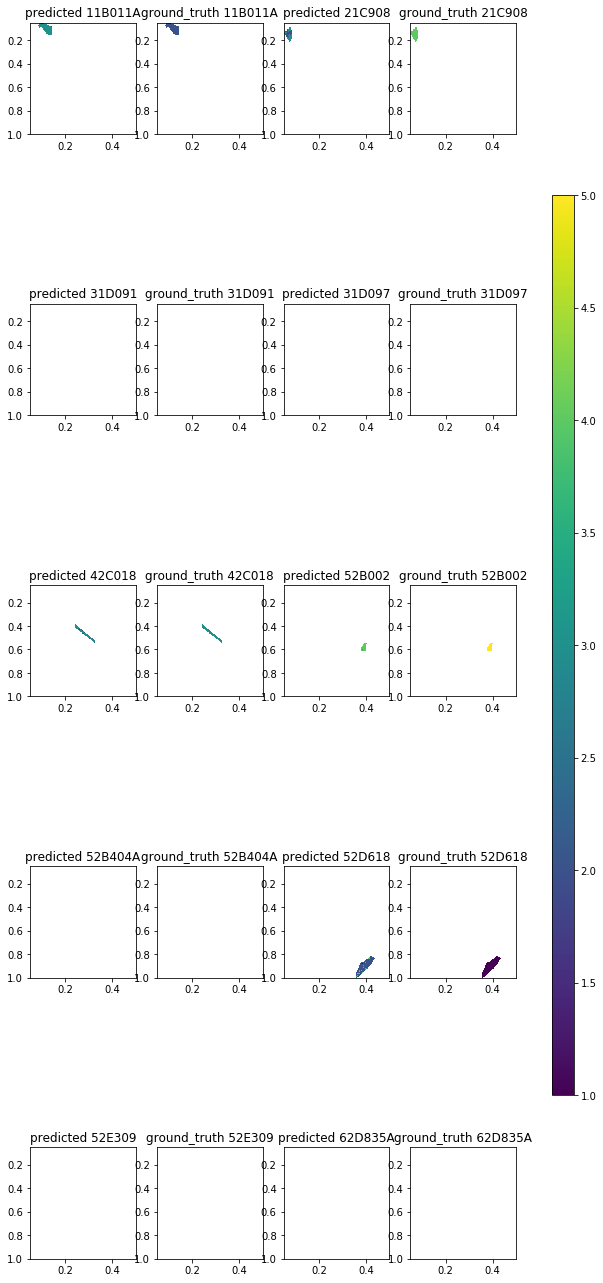

In [80]:
compare_predictions(xarr.isel(time=0))

In [99]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9e7f closed.


In [70]:
from sklearn_xarray import wrap
from dask_ml.preprocessing import StandardScaler
import xarray as xr
import numpy as np
import dask.array as da

X = xr.DataArray(
        da.from_array(np.random.random((100, 10)), chunks=(10, 10)),
        coords={'sample': range(100), 'feature': range(10)},
        dims=('sample', 'feature')
    )

Xt = wrap(StandardScaler()).fit_transform(X)
type(Xt.data)

Xt

<xarray.DataArray 'truediv-2c34bebbd12760ac852b9ca262399f6e' (sample: 100, feature: 10)>
dask.array<shape=(100, 10), dtype=float64, chunksize=(10, 10)>
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * feature  (feature) int64 0 1 2 3 4 5 6 7 8 9

## Rest of h2o.ai tutorial

In [81]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [82]:
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', balance_classes = True, seed=1)


# Initialize model
#rf_v1 = H2ORandomForestEstimator(
#    model_id="rf_covType_v1",
#    ntrees=500,
#    stopping_rounds=2,
#    score_each_iteration=True,
#    seed=100)
#gbm_fit1 = H2OGradientBoostingEstimator

In [83]:
train

IDLote,NDVI_0,NDVI_16,NDVI_32,NDVI_n112,NDVI_n16,NDVI_n32,NDVI_n48,NDVI_n64,NDVI_n80,NDVI_n96,VV_0,VV_16,VV_32,VV_ASM_0,VV_ASM_16,VV_ASM_32,VV_ASM_n112,VV_ASM_n128,VV_ASM_n144,VV_ASM_n16,VV_ASM_n160,VV_ASM_n176,VV_ASM_n192,VV_ASM_n208,VV_ASM_n32,VV_ASM_n48,VV_ASM_n64,VV_ASM_n80,VV_ASM_n96,VV_Contrast_0,VV_Contrast_16,VV_Contrast_32,VV_Contrast_n112,VV_Contrast_n128,VV_Contrast_n144,VV_Contrast_n16,VV_Contrast_n160,VV_Contrast_n176,VV_Contrast_n192,VV_Contrast_n208,VV_Contrast_n32,VV_Contrast_n48,VV_Contrast_n64,VV_Contrast_n80,VV_Contrast_n96,VV_Dissimilarity_0,VV_Dissimilarity_16,VV_Dissimilarity_32,VV_Dissimilarity_n112,VV_Dissimilarity_n128,VV_Dissimilarity_n144,VV_Dissimilarity_n16,VV_Dissimilarity_n160,VV_Dissimilarity_n176,VV_Dissimilarity_n192,VV_Dissimilarity_n208,VV_Dissimilarity_n32,VV_Dissimilarity_n48,VV_Dissimilarity_n64,VV_Dissimilarity_n80,VV_Dissimilarity_n96,VV_Energy_0,VV_Energy_16,VV_Energy_32,VV_Energy_n112,VV_Energy_n128,VV_Energy_n144,VV_Energy_n16,VV_Energy_n160,VV_Energy_n176,VV_Energy_n192,VV_Energy_n208,VV_Energy_n32,VV_Energy_n48,VV_Energy_n64,VV_Energy_n80,VV_Energy_n96,VV_Entropy_0,VV_Entropy_16,VV_Entropy_32,VV_Entropy_n112,VV_Entropy_n128,VV_Entropy_n144,VV_Entropy_n16,VV_Entropy_n160,VV_Entropy_n176,VV_Entropy_n192,VV_Entropy_n208,VV_Entropy_n32,VV_Entropy_n48,VV_Entropy_n64,VV_Entropy_n80,VV_Entropy_n96,VV_GLCMCorrelation_0,VV_GLCMCorrelation_16,VV_GLCMCorrelation_32,VV_GLCMCorrelation_n112,VV_GLCMCorrelation_n128,VV_GLCMCorrelation_n144,VV_GLCMCorrelation_n16,VV_GLCMCorrelation_n160,VV_GLCMCorrelation_n176,VV_GLCMCorrelation_n192,VV_GLCMCorrelation_n208,VV_GLCMCorrelation_n32,VV_GLCMCorrelation_n48,VV_GLCMCorrelation_n64,VV_GLCMCorrelation_n80,VV_GLCMCorrelation_n96,VV_GLCMMean_0,VV_GLCMMean_16,VV_GLCMMean_32,VV_GLCMMean_n112,VV_GLCMMean_n128,VV_GLCMMean_n144,VV_GLCMMean_n16,VV_GLCMMean_n160,VV_GLCMMean_n176,VV_GLCMMean_n192,VV_GLCMMean_n208,VV_GLCMMean_n32,VV_GLCMMean_n48,VV_GLCMMean_n64,VV_GLCMMean_n80,VV_GLCMMean_n96,VV_GLCMVariance_0,VV_GLCMVariance_16,VV_GLCMVariance_32,VV_GLCMVariance_n112,VV_GLCMVariance_n128,VV_GLCMVariance_n144,VV_GLCMVariance_n16,VV_GLCMVariance_n160,VV_GLCMVariance_n176,VV_GLCMVariance_n192,VV_GLCMVariance_n208,VV_GLCMVariance_n32,VV_GLCMVariance_n48,VV_GLCMVariance_n64,VV_GLCMVariance_n80,VV_GLCMVariance_n96,VV_Homogeneity_0,VV_Homogeneity_16,VV_Homogeneity_32,VV_Homogeneity_n112,VV_Homogeneity_n128,VV_Homogeneity_n144,VV_Homogeneity_n16,VV_Homogeneity_n160,VV_Homogeneity_n176,VV_Homogeneity_n192,VV_Homogeneity_n208,VV_Homogeneity_n32,VV_Homogeneity_n48,VV_Homogeneity_n64,VV_Homogeneity_n80,VV_Homogeneity_n96,VV_n112,VV_n128,VV_n144,VV_n16,VV_n160,VV_n176,VV_n192,VV_n208,VV_n32,VV_n48,VV_n64,VV_n80,VV_n96,time,tt,vclass,x,y,__index_level_0__
21C914,0.282755,0.301326,nan,nan,0.237963,0.886977,1.08404,0.884083,0.604007,0.401498,-6.81144,-9.50691,nan,-0.0148192,-0.165639,nan,2.70233,0.233923,0.359993,4.40326,0.664309,1.75831,0.571546,nan,-0.93358,0.473584,0.421863,0.15936,0.780442,41.8622,16.8198,nan,-3.06328,-10.1589,78.8441,-27.6502,19.0516,-36.933,36.0568,nan,135.991,5.12496,9.14076,24.6476,6.92442,7.53337,4.50843,nan,-0.172035,1.3565,9.7209,-1.97151,3.19976,-3.68256,6.47784,nan,10.4025,2.7044,3.95341,4.91113,2.62751,0.403614,0.421322,nan,1.70697,0.616559,0.555831,2.12353,0.802769,1.42604,0.722651,nan,-0.142388,0.631041,0.676203,0.526454,0.895009,4.65294,4.45107,nan,-0.586453,3.06791,4.06458,-1.96141,2.60074,-0.540986,2.94295,nan,2.71806,2.59412,3.69741,4.10838,2.31707,0.824696,0.874445,nan,0.9276,0.93371,0.565192,1.01165,0.837912,1.14738,0.579383,nan,0.198218,0.697833,0.901603,0.868479,0.991084,14.8682,10.9121,nan,2.62375,7.23629,10.0192,-1.52636,5.2672,-0.141424,6.8101,nan,19.1867,4.99048,7.86409,18.0371,29.7947,121.586,70.8866,nan,22.1279,32.4738,83.3017,-54.3141,25.5542,-31.0305,37.833,nan,285.999,13.8577,35.1977,187.974,428.365,0.448537,0.560812,nan,1.89568,1.05223,0.408397,2.11421,1.17585,2.02134,0.708882,nan,-0.139036,0.724973,0.659135,0.813096,1.07129,-13.8

In [86]:
rf_fit1.train(x=x, y=y, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [172]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [107]:
data_test['train'] = data_test['test']

In [89]:
rf_perf1 = rf_fit1.model_performance()
rf_perf1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.002176173066882767
RMSE: 0.04664947016722448
LogLoss: 0.019300008969039297
Mean Per-Class Error: 0.0001739889396833573
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
9184.0,0.0,0.0,0.0,0.0,0.0,"0 / 9,184"
0.0,9174.0,0.0,0.0,0.0,0.0,"0 / 9,174"
0.0,0.0,9203.0,4.0,0.0,0.0004345,"4 / 9,207"
0.0,4.0,0.0,9181.0,0.0,0.0004355,"4 / 9,185"
0.0,0.0,0.0,0.0,9222.0,0.0,"0 / 9,222"
9184.0,9178.0,9203.0,9185.0,9222.0,0.0001740,"8 / 45,972"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9998259
2,1.0
3,1.0
4,1.0
5,1.0


drf prediction progress: |████████████████████████████████████████████████| 100%
Prediction accuracy: 0.26883715699505173


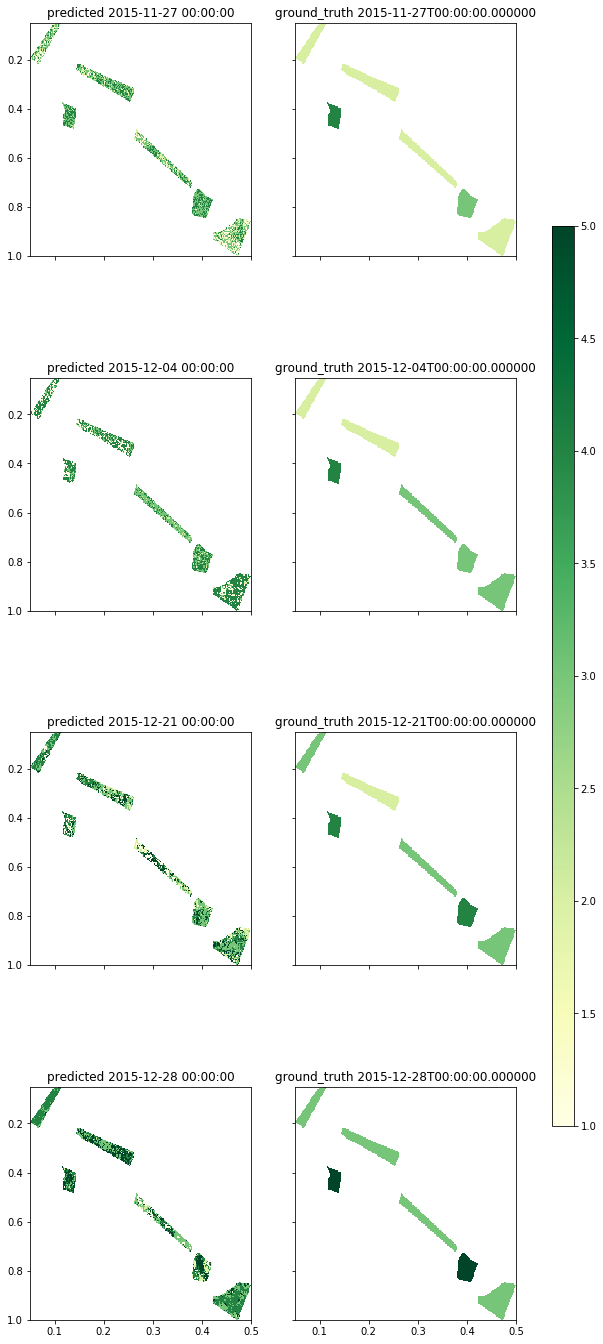

In [114]:
compare_predictions(rf_fit1, data_test)

In [119]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [90]:
# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [91]:
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [159]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='misclassification',     #used for early stopping
                                        #stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [92]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
#gbm_perf3 = gbm_fit3.model_performance(data_test)

In [93]:
# Retreive test set AUC
print(gbm_perf1)
print(gbm_perf2)
#print(gbm_perf3)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.7260192918829322
RMSE: 0.8520676568694133
LogLoss: 3.8697527652585877
Mean Per-Class Error: 0.8568680656109139
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
21.0,1553.0,8.0,11.0,0.0,0.9868173,"1,572 / 1,593"
1.0,11.0,1000.0,962.0,0.0,0.9944276,"1,963 / 1,974"
261.0,219.0,1647.0,493.0,1028.0,0.5485197,"2,001 / 3,648"
2.0,638.0,628.0,590.0,546.0,0.7545757,"1,814 / 2,404"
0.0,0.0,0.0,358.0,0.0,1.0,358 / 358
285.0,2421.0,3283.0,2414.0,1574.0,0.7725769,"7,708 / 9,977"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2274231
2,0.4772978
3,0.7565401
4,0.9608099
5,1.0




ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.7346150643079511
RMSE: 0.8570968815180412
LogLoss: 12.998162202089159
Mean Per-Class Error: 0.8398103931951836
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
1.0,1563.0,0.0,29.0,0.0,0.9993723,"1,592 / 1,593"
0.0,13.0,979.0,982.0,0.0,0.9934144,"1,961 / 1,974"
697.0,131.0,1806.0,452.0,562.0,0.5049342,"1,842 / 3,648"
3.0,629.0,598.0,718.0,456.0,0.7013311,"1,686 / 2,404"
0.0,0.0,0.0,358.0,0.0,1.0,358 / 358
701.0,2336.0,3383.0,2539.0,1018.0,0.7456149,"7,439 / 9,977"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2543851
2,0.4581538
3,0.7205573
4,0.9425679
5,1.0


gbm prediction progress: |████████████████████████████████████████████████| 100%
Prediction accuracy: 0.2706365272154746


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


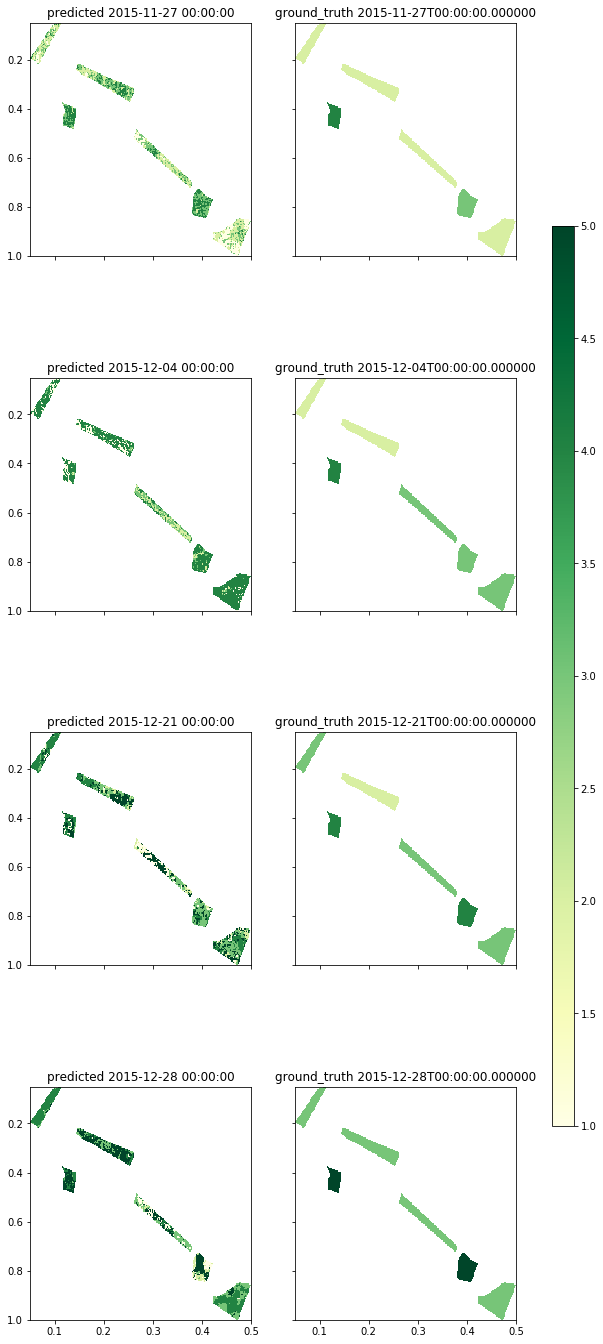

In [162]:
compare_predictions(gbm_fit1, data_test)

In [94]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [95]:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [96]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [151]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='misclassification',     #used for early stopping
                                   #stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [97]:
dl_perf1 = dl_fit1.model_performance(test)
dl_perf2 = dl_fit2.model_performance(test)
#dl_perf3 = dl_fit3.model_performance(data_test)

In [98]:
# Retreive test set AUC
print(dl_perf1)
print(dl_perf2)
#print(dl_perf3)


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.7050135044865603
RMSE: 0.839650822953542
LogLoss: 17.519950470602296
Mean Per-Class Error: 0.799730714581594
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
139.0,1116.0,82.0,256.0,0.0,0.9127433,"1,454 / 1,593"
6.0,225.0,583.0,1159.0,1.0,0.8860182,"1,749 / 1,974"
302.0,174.0,1547.0,71.0,1554.0,0.5759320,"2,101 / 3,648"
14.0,381.0,914.0,904.0,191.0,0.6239601,"1,500 / 2,404"
0.0,0.0,0.0,358.0,0.0,1.0,358 / 358
461.0,1896.0,3126.0,2748.0,1746.0,0.7178511,"7,162 / 9,977"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2821490
2,0.4512379
3,0.6402726
4,0.8552671
5,1.0




ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.7387241408624404
RMSE: 0.8594906287228735
LogLoss: 15.486074346820088
Mean Per-Class Error: 0.8338489621101249
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
1.0,1463.0,2.0,127.0,0.0,0.9993723,"1,592 / 1,593"
1.0,20.0,1002.0,951.0,0.0,0.9898683,"1,954 / 1,974"
141.0,470.0,1398.0,95.0,1544.0,0.6167763,"2,250 / 3,648"
0.0,350.0,938.0,1050.0,66.0,0.5632280,"1,354 / 2,404"
0.0,0.0,0.0,358.0,0.0,1.0,358 / 358
143.0,2303.0,3340.0,2581.0,1610.0,0.7525308,"7,508 / 9,977"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2474692
2,0.4632655
3,0.6209282
4,0.8075574
5,1.0


deeplearning prediction progress: |███████████████████████████████████████| 100%
Prediction accuracy: 0.3833783175888439


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


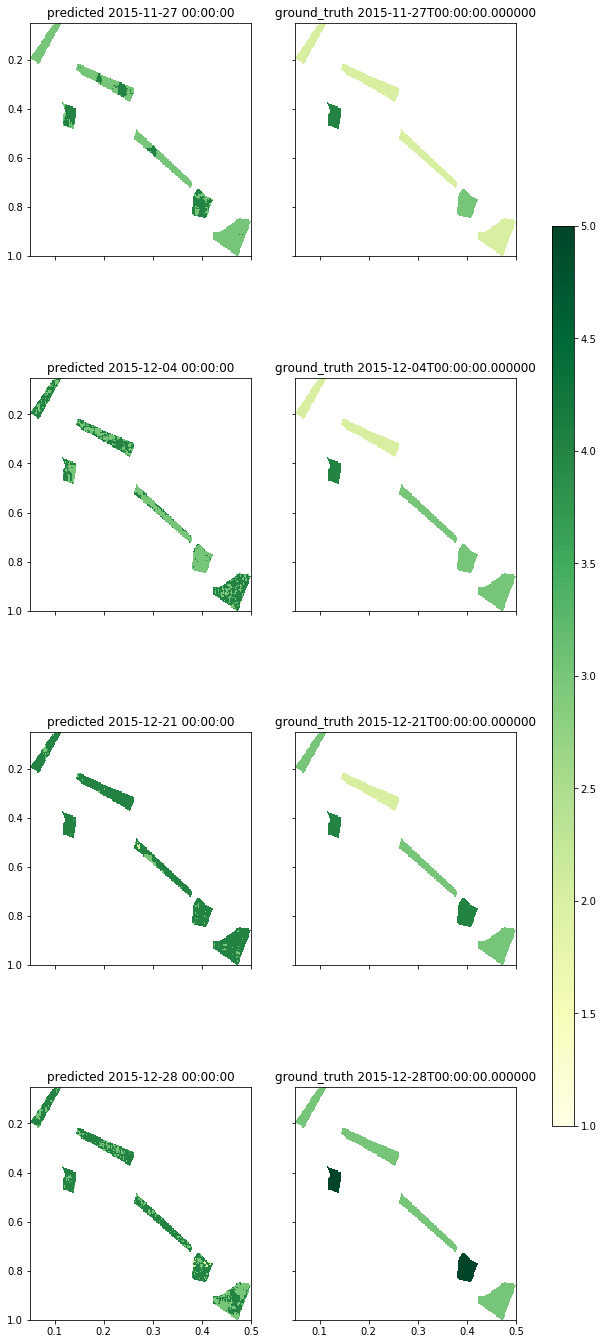

In [156]:
compare_predictions(dl_fit3, data_test)

In [140]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit1.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [141]:
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)
nb_fit2.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [143]:
nb_perf1 = nb_fit1.model_performance(data_test)
nb_perf2 = nb_fit2.model_performance(data_test)

In [144]:
# Retreive test set AUC
print(nb_perf1)#.auc()
print(nb_perf2)#.auc()


ModelMetricsMultinomial: naivebayes
** Reported on test data. **

MSE: 0.6428137757212611
RMSE: 0.8017566811204389
LogLoss: 8.684570795782838
Mean Per-Class Error: 0.6559728969246914
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
0.0,0.0,0.0,0.0,0.0,nan,0 / 0
2490.0,107.0,1261.0,229.0,188.0,0.9749708,"4,168 / 4,275"
855.0,254.0,2615.0,3053.0,865.0,0.6578121,"5,027 / 7,642"
665.0,52.0,1591.0,1409.0,1430.0,0.7262483,"3,738 / 5,147"
292.0,94.0,0.0,277.0,57.0,0.9208333,663 / 720
4302.0,507.0,5467.0,4968.0,2540.0,0.7645074,"13,596 / 17,784"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2354926
2,0.5178812
3,0.7149122
4,0.8408119
5,0.9999999




ModelMetricsMultinomial: naivebayes
** Reported on test data. **

MSE: 0.6428325296364288
RMSE: 0.8017683765505028
LogLoss: 8.684464770332518
Mean Per-Class Error: 0.6560514104028385
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
0.0,0.0,0.0,0.0,0.0,nan,0 / 0
2490.0,107.0,1260.0,229.0,189.0,0.9749708,"4,168 / 4,275"
856.0,257.0,2612.0,3055.0,862.0,0.6582047,"5,030 / 7,642"
665.0,55.0,1590.0,1409.0,1428.0,0.7262483,"3,738 / 5,147"
291.0,95.0,0.0,277.0,57.0,0.9208333,663 / 720
4302.0,514.0,5462.0,4970.0,2536.0,0.7646761,"13,599 / 17,784"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.2353239
2,0.5178813
3,0.7149686
4,0.8409807
5,1.0
